<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TrainNVP_and_measure_Reconstruction_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
sys.path.append('../')
from vae.model import get_prior, get_posterior, get_likelihood

In [4]:
import vae.create_datasets as crd

W1104 12:07:56.325849 139750785632064 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
likelihood  = 'Gauss'
class_label = -1
network_type= 'fully_connected'
data_set    = 'mnist'
latent_size = 8
AE          = True

In [6]:
if AE:
    params = pickle.load(open('../params/params_%s_%s_%d_%d_%s-AE.pkl'%(data_set,likelihood,class_label,latent_size, network_type),'rb'))
else:
    params = pickle.load(open('../params/params_%s_%s_%d_%d_%s.pkl'%(data_set,likelihood,class_label,latent_size,network_type),'rb'))
module_dir = params['module_dir']+'/vae'
model_dir  = params['model_dir']
params['add_noise']=False

In [7]:
all_subdirs   = [os.path.join(module_dir,d) for d in os.listdir(module_dir+'/') if os.path.isdir(os.path.join(module_dir,d))]
latest_subdir = max(all_subdirs, key=os.path.getmtime)

In [8]:
generator_path   = os.path.join(latest_subdir,'decoder')
encoder_path     = os.path.join(latest_subdir,'encoder')

In [9]:
nvp_depth = 6
indices   = np.arange(params['latent_size'])
permutations = [np.random.permutation(indices) for ii in range(nvp_depth)]

In [10]:
train_input_fn, eval_input_fn = crd.build_input_fns(params,label=params['class_label'],flatten=True)

loading mnist dataset


In [11]:
tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.001,shape=[])
sigma         = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(16,shape=[])
data          = train_input_fn()
testdata      = eval_input_fn()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

prior         = get_prior(params['latent_size'])
posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params['likelihood'],sigma)

# inspect the model
z_    = posterior(testdata).mean()
prior_sample = prior.sample(sample_size)
x     = likelihood(prior_sample).mean()
recon = likelihood(z_).mean()



### ----------- NVP ----------- ###
def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)


nvp_size      = [[512, 512] for ii in range(nvp_depth)]


def get_nvp():
    base_dis = get_prior(params['latent_size'])
    chain    = []
  
    perms         = [tfb.Permute(permutation=init_once(permutations[ii],name="permutation%d"%ii)) for ii in range(nvp_depth)]
  
    for i,s in enumerate(nvp_size):
        if i==0:
            chain.append(perms[i])
        if i>2:
            chain.append(tfb.RealNVP(num_masked=params['latent_size']//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i, shift_only=True)))
        else:
            chain.append(tfb.RealNVP(num_masked=params['latent_size']//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
    chain.append(perms[i])

    nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

z         = posterior(data).mean()
loss      = -tf.reduce_mean(nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])

opt_op_nvp = optimizer.minimize(loss)

nvp_sample = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample}, as_dict=True)['fwd_pass']
x_new      = likelihood(nvp_sample).mean()

# # ---------------------------end train nvp ----------------- #

# #comment train nvp above section above and uncomment this for loading the trained module

# #nvp_funcs     = hub.Module(nvp_func_path, trainable=False)

W1104 12:07:57.411854 139750785632064 deprecation.py:323] From ../vae/create_datasets.py:68: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W1104 12:07:57.641692 139750785632064 deprecation_wrapper.py:119] From ../vae/model.py:78: The name tf.variable_scope is deprecated

mean Tensor("module_1_apply_default/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_1_apply_default_1/model/decoder/dense_4/BiasAdd:0", shape=(64, 784), dtype=float32)


W1104 12:07:58.872413 139750785632064 deprecation.py:323] From /home/nessa/miniconda3/envs/tflow/lib/python3.7/site-packages/tensorflow_hub/saved_model_lib.py:110: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


mean Tensor("module_1_apply_default_2/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)


In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
rec, d = sess.run([recon,data])

In [14]:
x_sample = sess.run(x)

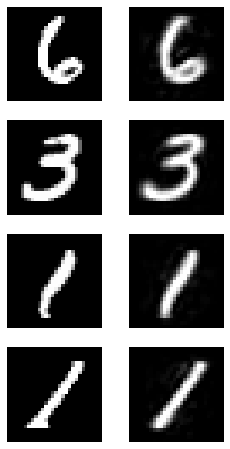

In [15]:
jj=1
plt.figure(figsize=(2*2,4*2))
for ii in range(4):
    plt.subplot(4,2,jj)
    plt.imshow(d[ii].reshape(28,28),cmap='gray')
    plt.axis('off')
    jj+=1
    plt.subplot(4,2,jj)
    plt.imshow(rec[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1


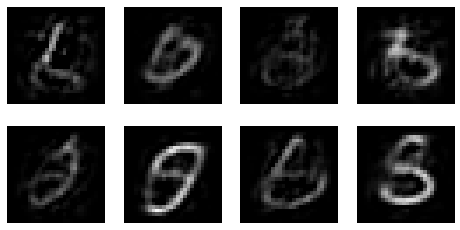

In [16]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(x_sample[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

In [17]:
z_sample=[]
for ii in range(1000):
    z_sample+=[sess.run(z)]
z_sample=np.asarray(z_sample)

W1104 12:08:02.993587 139750785632064 font_manager.py:1282] findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


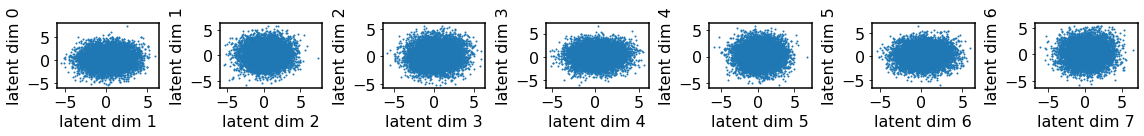

In [18]:
plt.figure(figsize=((latent_size-1)*2+2,2))
for nn in range(latent_size-1):
    plt.subplot(1,latent_size-1,nn+1)
    plt.scatter(z_sample[:,nn],z_sample[:,nn+1],s=1) 
    plt.ylabel('latent dim %d'%nn)
    plt.xlabel('latent dim %d'%(nn+1))
    plt.tight_layout()

**Training of the NVP**

In [19]:
nvp_loss = []

In [ ]:
ii     = 0
nepoch = 0
learning_rate = 1e-4

#train the nvp
while nepoch<1000:
    _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate})
    nvp_loss+=[ll]
    if ii%1000==0:
        print(np.mean(nvp_loss[-50::]))
    ii+=1

15.324092
15.412519
15.266862
15.482889
15.328531
15.2866335
15.458417
15.311981
15.3123255
15.3466
15.375829
15.217799
15.196961
15.460703
15.299482
15.327309
15.418354
15.257689
15.29902
15.258262
15.30209
15.349931
15.238533
15.207251
15.184204
15.339184
15.374617
15.297815
15.165014
15.258603
15.277757
15.146921
15.356379
15.272466
15.21524
15.34269
15.340562
15.290169
15.213823
15.235056
15.276372
15.272125
15.081709
15.258025
15.442926
15.115326
15.27058
15.333134
15.313026
15.341356
14.974434
15.378576
15.290097
15.245278
15.185034
15.208461
15.313186
15.211536
15.252136
15.269735
15.161435
15.2315855
15.128343
15.218754
15.183524
15.1557255
15.147488
15.158453
15.1232605
15.382202
15.150107
15.142987
15.254242
15.08782
15.278309
15.225336
15.29463
15.259038
15.119021
15.1877
15.158134
15.2151575
15.165192
15.108813
15.156965
15.168331
15.303217
15.160026
15.073893
15.08596
15.201489
15.183094
15.18515
15.320643
15.17677
15.185753
15.22916
15.196288
15.172981
15.201778
15.035466

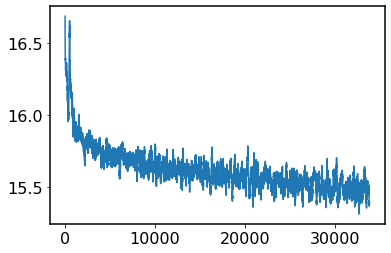

In [22]:
plt.figure()
plt.plot(np.convolve(nvp_loss[::],np.ones((100))/100., mode='valid'),label='nvp loss')

In [23]:
s_nvp       = sess.run(x_new)
s           = sess.run(x)
z_sample_nvp = sess.run(nvp_sample,feed_dict={sample_size:10000})

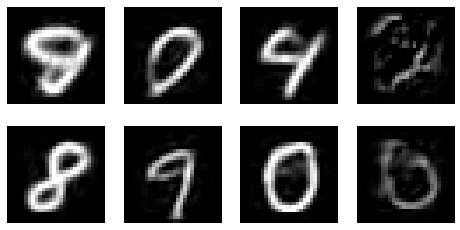

In [24]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(s_nvp[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

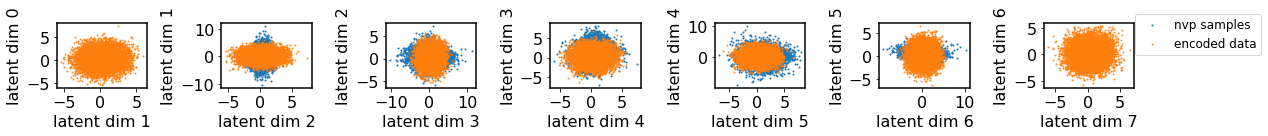

In [27]:
plt.figure(figsize=((latent_size-1)*2+2,2))
for nn in range(latent_size-1):
    plt.subplot(1,latent_size-1,nn+1)
    plt.scatter(z_sample_nvp[:,nn],z_sample_nvp[:,nn+1],s=1, label='nvp samples') 
    plt.scatter(z_sample[:,nn],z_sample[:,nn+1],s=1,alpha=0.8, label='encoded data') 
    plt.ylabel('latent dim %d'%nn)
    plt.xlabel('latent dim %d'%(nn+1))
    plt.tight_layout()
plt.legend(loc=(1.01,0.5))

In [26]:
nvp_dir          = os.path.join(params['module_dir'],'nvp')
if not os.path.isdir(nvp_dir):
    os.makedirs(nvp_dir)
nvp_funcs.export(nvp_dir,sess)

AlreadyExistsError: file already exists